In [4]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

c:\Users\user\.vscode\anime\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load theme classifier ( Zero shot classifier Model ) :

In [6]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else "cpu"

In [7]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [8]:
theme_classifier = load_model(device)

In [9]:
theme_list = ['Friendship', 'Love', 'Adventure', 'Evil', 'Humor', 'Fantasy', 'battle', 'hope','sacrifice']

In [10]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list ,
    multi_label = True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'Fantasy',
  'Adventure',
  'hope',
  'Humor',
  'sacrifice',
  'Evil',
  'Friendship',
  'Love'],
 'scores': [0.9121254682540894,
  0.302327424287796,
  0.2797655463218689,
  0.08781813830137253,
  0.050267815589904785,
  0.045000508427619934,
  0.03511766716837883,
  0.005728323478251696,
  0.004789733327925205]}

## Load subtitles Dataset :

In [11]:
files = glob("../data/subtitles/*.ass")

In [12]:
files[:3]

['../data/subtitles\\Naruto Season 1 - 01.ass',
 '../data/subtitles\\Naruto Season 1 - 02.ass',
 '../data/subtitles\\Naruto Season 1 - 03.ass']

In [13]:
with open(files[0],'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines =  [ ",".join(line.split(',')[9:])  for line in lines ]

In [14]:
lines

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n',
 'it could smash mountains\\Nand create tidal waves.\n',
 'A band of Ninjas rose to\\Ndefend their village from attack.\n',
 'We have to wait until\\Nthe Fourth Hokage gets here!\n',
 "We can't let it get any closer\\Nto our village!\n",
 'One great Ninja was able to\\Nimprison the monster,\n',
 'but died in the process.\n',
 'This Ninja was known asâ€¦\\Nthe Fourth Hokage.\n',
 'Naruto!\n',
 'Why did you do such a thing?!\n',
 "You're really gonna get it this time!\n",
 "I don't care!\n",
 'You know your problem?\n',
 "You can't do the things I do!\n",
 'Only I can do this!\n',
 "I'm better than all of you!\\NBelieve it!\n",
 "There's a problem, sir!\n",
 'Lord Hokage!\n',
 'What is it?\n',
 'Did that Naruto do something again?\n',
 'Yes. He climbed onto\\Nthe Mountainside Imagesâ€¦\n',
 'And he vandalized and\\Ngraffitied all over them!\n',
 'Wait!\n',
 'Ha haâ€¦\n',
 'Why should I?

In [15]:
lines[0]

'A long time ago, a powerful demon fox\\Nappeared with nine tails.\n'

## Some Cleaning :

In [16]:
lines = [ line.replace("\\N"," ") for line in lines ]

In [17]:
" ".join(lines[:20])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known asâ€¦ the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You're really gonna get it this time!\n I don't care!\n You know your problem?\n You can't do the things I do!\n Only I can do this!\n I'm better than all of you! Believe it!\n There's a problem, sir!\n Lord Hokage!\n What is it?\n"

## Get episode no. :

In [18]:
files[0]

'../data/subtitles\\Naruto Season 1 - 01.ass'

In [19]:
files[0].split("-")[-1]

' 01.ass'

In [20]:
int(files[0].split("-")[-1].split(".")[0].strip())

1

## all these steps In 1 function :

In [21]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        # read Lines
        with open(path, 'r', encoding='utf-8') as file: 
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]
        
       # clean 
        lines = [ line.replace('\\N',' ') for line in lines]
        # join some lines
        script = " ".join(lines)
        # get no. of episode 
        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [22]:
dataset_path = "../data/subtitles"
df = load_subtitles_dataset(dataset_path)
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


### Run Model on df :

In [23]:
script = df.iloc[0]["script"]
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

### To fit nlp token maximum :

In [24]:
script_sentence = sent_tokenize(script)
script_sentence[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [25]:
sentence_batch_size = 20
script_batches = []
for index in range(0,len(script_sentence),sentence_batch_size):
    sent = " ".join(script_sentence[index:index+sentence_batch_size])
    script_batches.append(sent)


In [26]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [27]:
script_batches[0]

"A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?"

In [28]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [29]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['battle',
   'Adventure',
   'sacrifice',
   'Evil',
   'Fantasy',
   'Humor',
   'hope',
   'Friendship',
   'Love'],
  'scores': [0.8546884655952454,
   0.8196924328804016,
   0.7349814772605896,
   0.42211613059043884,
   0.2756846249103546,
   0.23392079770565

In [30]:
themes = {}
for output in theme_output :
    for label , score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)
    

In [31]:
themes

{'battle': [0.8546884655952454, 0.6581320762634277],
 'Adventure': [0.8196924328804016, 0.6013889908790588],
 'sacrifice': [0.7349814772605896, 0.6258841156959534],
 'Evil': [0.42211613059043884, 0.4478292167186737],
 'Fantasy': [0.2756846249103546, 0.48074260354042053],
 'Humor': [0.23392079770565033, 0.7009299993515015],
 'hope': [0.19909833371639252, 0.2042398750782013],
 'Friendship': [0.06264949589967728, 0.04141798987984657],
 'Love': [0.057543303817510605, 0.051657602190971375]}

## all these steps In 1 function :

In [32]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [33]:
df = df.head(2)
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [34]:
output_themes = df['script'].apply(get_themes_inference)
output_themes 

0    {'battle': 0.7564102709293365, 'Adventure': 0....
1    {'Adventure': 0.57619908452034, 'sacrifice': 0...
Name: script, dtype: object

In [35]:
theme_df = pd.DataFrame(output_themes.tolist())
theme_df

,battle,Adventure,sacrifice,Evil,Fantasy,Humor,hope,Friendship,Love
0,0.756410,0.710541,0.680433,0.434973,0.378214,0.467425,0.201669,0.052034,0.054600
1,0.684845,0.576199,0.570704,0.335240,0.260640,0.283484,0.154533,0.047754,0.091052


In [39]:
df[theme_df.columns] = theme_df
df

,episode,script,battle,Adventure,sacrifice,Evil,Fantasy,Humor,hope,Friendship,Love
0,1,"A long time ago, a powerful demon fox appeared...",0.756410,0.710541,0.680433,0.434973,0.378214,0.467425,0.201669,0.052034,0.054600
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.684845,0.576199,0.570704,0.335240,0.260640,0.283484,0.154533,0.047754,0.091052


## Visualize  Output : 

In [40]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output

,index,0
0,battle,1.441256
1,Adventure,1.286740
2,sacrifice,1.251137
3,Evil,0.770212
4,Fantasy,0.638854
5,Humor,0.750909
6,hope,0.356202
7,Friendship,0.099788
8,Love,0.145653


In [41]:
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,battle,1.441256
1,Adventure,1.286740
2,sacrifice,1.251137
3,Evil,0.770212
4,Fantasy,0.638854
5,Humor,0.750909
6,hope,0.356202
7,Friendship,0.099788
8,Love,0.145653


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

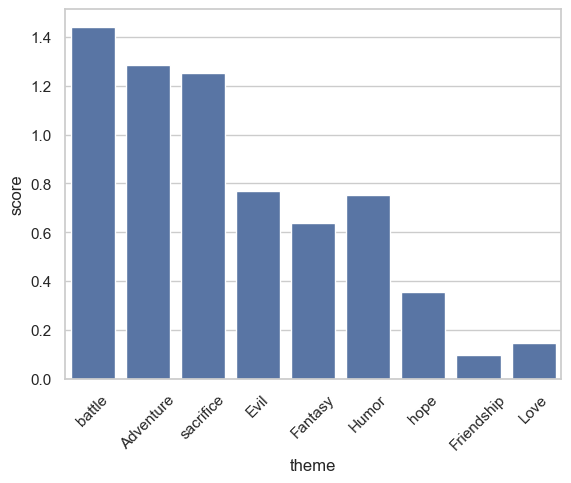

In [43]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()

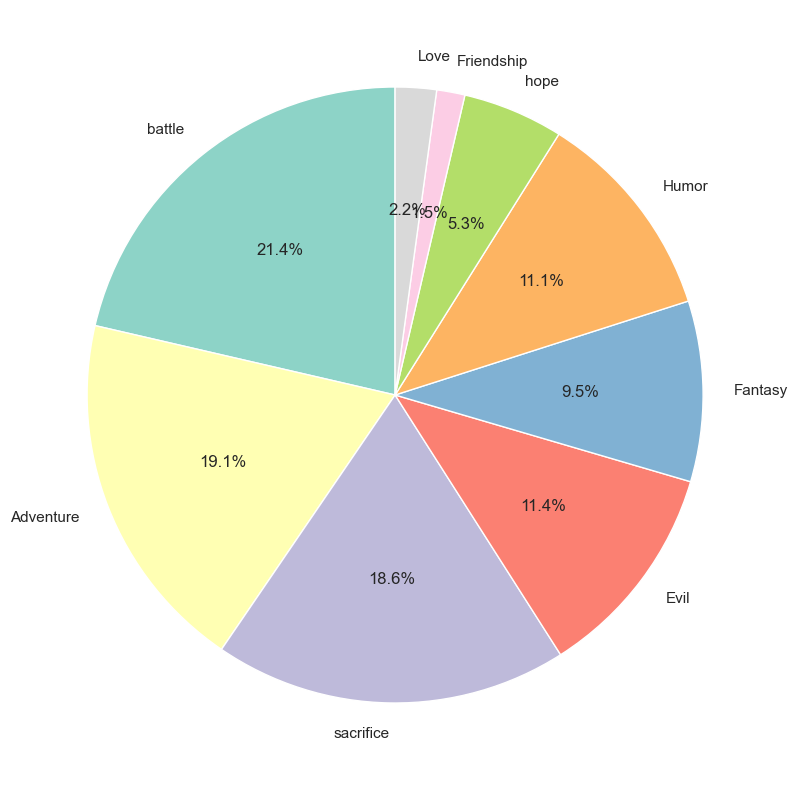

In [124]:
plt.figure(figsize=(10, 10))  
plt.pie(theme_output['score'], labels=theme_output['theme'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))  
plt.show() 